In [79]:
import json
import os
import pickle
from collections import defaultdict
from glob import glob
from pathlib import Path
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rcParams
from matplotlib.lines import Line2D
from rdkit import Chem
from rdkit.Chem import AllChem

from plot_utils import *
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import copy
import re 
from sklearn.neighbors import NearestNeighbors
from matplotlib.ticker import PercentFormatter

params = {
    'font.size': 18,
    'legend.fontsize': 18,
    'text.usetex': False,
}
rcParams.update(params)

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import warnings
warnings.filterwarnings('ignore')

In [80]:
sub = ['(Cl)', '(OC)', '(Cl)', '(N(C)C)', '(O)', '(N)', '(C)', '([N+](=O)[O-])', '(C#N)', '(C(C)=O)', '(C(N)=O)', '(S(N)(=O)=O)', '(S(C)(=O)=O)', '(C(C)(C)C)', '(C(F)(F)F)', '(Br)', '(I)']

def topliss_walk(smiles, n_combinations=2):
    mols = [smiles]
    for step in range(n_combinations):
        new_mols = []
        for mol in mols: 
            positions = [m.start() for m in re.finditer('c', mol)]
            for p in positions:
                for s in sub:
                    if Chem.MolFromSmiles(mol[:p] + s + mol[p:]):
                        new_mols.append(mol[:p] + s + mol[p:])
        mols.extend(new_mols)
    return mols

def one_ecfp(smile, radius=2):
    "Calculate ECFP fingerprint. If smiles is invalid return none"
    try:
        m = Chem.MolFromSmiles(smile)
        fp = np.array(AllChem.GetMorganFingerprintAsBitVect(
            m, radius, nBits=1024))
        return fp
    except:
        return None
    
def ecfp(smiles):
    """Input: list of SMILES
       Output: list of descriptors.
       Compute ECFP4 featurization."""
    X = [one_ecfp(s, radius=2) for s in smiles]
    return X

In [81]:
def fit_clfs(df, is_aldh1=False, topliss_augmented=False):
    """
    Args:
        chid: which assay to use:
        external_file:
    Returns:
        clfs: Dictionary of fitted classifiers
        aucs: Dictionary of AUCs
        balance: Two numbers showing the number of actives in split 1 / split 2
        df1: data in split 1
        df2: data in split 2
    """
    # read data and calculate ecfp fingerprints

    
    if is_aldh1:
        df = pd.read_csv("210415_LIT_PCBA_ALDH1_Best_AB_sets.csv")
        in_set_A = np.where(df['in_set_A']==1)[0]
        in_set_B = np.where(df['in_set_B']==1)[0]
        smiles = df["SMILES"]
        activity = df["Act"]
        index_test = []
        for i in range(len(smiles)):
            if i not in in_set_A and i not in in_set_B:
                index_test.append(i)

        in_test = np.array(index_test)

        #in_test = np.where(df['in_set_A']==0 and df['in_set_B']==0)


        X1 = np.array(ecfp(smiles[in_set_A]))
        X2 = np.array(ecfp(smiles[in_set_B]))

        y1 = np.array(activity[in_set_A])
        y2 = np.array(activity[in_set_B])
        smiles_test = np.array(smiles)[in_test]
    else:
        df['ecfp'] = ecfp(df.smiles)
        df_train, df_test = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=0)


        df1, df2 = train_test_split(df_train, test_size=0.5, stratify=df_train['label'], random_state=0)
        X1 = np.array(list(df1['ecfp']))
        X2 = np.array(list(df2['ecfp']))

        y1 = np.array(list(df1['label']))
        y2 = np.array(list(df2['label']))

        del df1['ecfp']
        del df2['ecfp']
        smiles_test = df_test.smiles
    
    
    balance = (np.mean(y1), np.mean(y2))
    clf_1 = RandomForestClassifier(
        n_estimators=100, random_state=0, min_samples_leaf=1, max_depth=None)

    clf_2 = RandomForestClassifier(
        n_estimators=100, random_state=0)
    clf_1.fit(X1, y1)
    clf_2.fit(X2, y2)
    test_scores = clf_1.predict_proba(ecfp(smiles_test))[:, 1]
    
    if topliss_augmented:
        augmented_smiles_test = []
        for i, s in enumerate(smiles_test):
            if test_scores[i]>0.25:
                augmented_smiles_test.extend(topliss_walk(s, n_combinations=2))
            else:
                augmented_smiles_test.extend([s])
        augmented_smiles_test = np.array(augmented_smiles_test)
        X_test = ecfp(augmented_smiles_test)
    else:
        augmented_smiles_test = smiles_test
        X_test = ecfp(augmented_smiles_test)

    scores_1 = clf_1.predict_proba(X_test)[:, 1]
    scores_2 = clf_2.predict_proba(X_test)[:, 1]

    return df1.smiles, df2.smiles, y1, y2, augmented_smiles_test, scores_1, scores_2

def get_sims(smiles_1, smiles_2):
    neigh = NearestNeighbors(10, 0.1, metric='jaccard', algorithm='brute')
    neigh.fit(ecfp(smiles_2))
    sims = []
    for x in ecfp(smiles_1):
        dist, idx = neigh.kneighbors(x.reshape(1, -1))
        sims.extend(dist[0])
    return sims

In [82]:
def load_chid(chid_dir, order, **kwargs):
    runs = [run for run in os.listdir(chid_dir) if os.path.isfile(chid_dir / run / 'results.json')]
    accumulate = []
    for run in runs:
        run_dir = chid_dir / run
        with open(run_dir / 'results.json', 'r') as f:
            results = json.load(f)

        # some runs aborted earlier. Solve this by adding the last entry a few times!
        # TODO: solve this in a better way.
        n_gen = len(results['statistics'])

        if n_gen != 151:
            results['statistics'] += [results['statistics'][-1]] * \
                (151 - n_gen)

        # create a dictionary containing arrays of shape [n_iter, n_molecules]
        preds_internal = flatten([row['preds']
                                  for row in results['statistics']])
        smiles = [row['smiles'] for row in results['statistics']]
        # array for each clf and split
        preds_external = results['predictions_external']
        accumulate.append((preds_internal, preds_external,
                           results['AUC'], smiles, ))

    # preds_internal, preds_external, aucs = [flatten(x) for x in list(zip(*accumulate))]
    preds_internal, preds_external, aucs, smiles, = list(
        zip(*accumulate))
    preds_internal = flatten(preds_internal)
    preds_external = flatten(preds_external)
    aucs = flatten(aucs)
    # legacy compatibility
    for d in [preds_internal, preds_external, aucs]:
        if 'all' in d:
            del d['all']
    preds_internal, preds_external, aucs = [
        {k: d[k] for k in order} for d in [preds_internal, preds_external, aucs]]
    return preds_internal, preds_external, aucs, smiles

def get_chid_values(chid):
    assay_file = 'assays/processed/' + chid + '.csv'
    print('Reading data from: {assay_file}')
    df = pd.read_csv(assay_file)

    df['ecfp'] = ecfp(df.smiles)
    df1, df2 = train_test_split(df, test_size=0.5, stratify=df['label'], random_state=1)

    X1 = np.array(list(df1['ecfp']))
    X2 = np.array(list(df2['ecfp']))

    y1 = np.array(list(df1['label']))
    y2 = np.array(list(df2['label']))

    del df1['ecfp']
    del df2['ecfp']

    balance = (np.mean(y1), np.mean(y2))

    # train classifiers and store them in dictionary
    clf = RandomForestClassifier(
        n_estimators=100, random_state=0)
    clf.fit(X1, y1)
    scores = clf.predict_proba(X2)[:, 1][np.where(y2==1)]
    scores_inactive = clf.predict_proba(X1)[np.where(y1==0)]
    #scores = scores_inactive
    return np.mean(scores), np.percentile(scores,5), np.percentile(scores, 95), np.median(scores_inactive), np.percentile(scores_inactive,25), np.percentile(scores_inactive, 75)

def median_score_compound(pred, color=None, label=None, shade=False, **kwargs):
    # pred is triply nested list [n_runs, n_epochs, n_mol(variable_size) ]
    # get mean scores over runs
    pred_mean = np.array([[np.mean([z for z in y if z is not None]) for y in x] for x in pred]).T
    median = np.median(pred_mean, 1)
    q25 = np.percentile(pred_mean, 25, axis=1)
    q75 = np.percentile(pred_mean, 75, axis=1)

    plt.plot(median, c=color, label=label, **kwargs)

    plt.fill_between(
        np.arange(median.shape[0]), q25, q75, alpha=.1, color=color)
    
def median_score_single(pred, color=None, label=None, **kwargs):
    medians = np.array([[np.median([t for t in y if t is not None]) for y in x] for x in pred])
    q25 = np.array([[np.percentile([t for t in y if t is not None], 25) for y in x] for x in pred])
    q75 = np.array([[np.percentile([t for t in y if t is not None], 75) for y in x] for x in pred])
    n_runs = medians.shape[0]
    for i in range(n_runs):
        plt.plot(medians[i], c=color, label=label, **kwargs)
        label = None  # avoid multiple legend entries
        plt.fill_between(
            np.arange(medians[i].shape[0]), q25[i], q75[i], alpha=.1, color=color)

def plot_wrapper(preds_internal, primitive, name, col_dict, legend_dict, ls_dict, skip=[], xlabel=None, ylabel=None, ax=None, legend=True, leg_lw=3, **kwargs):
    if ax is not None:
        plt.sca(ax)
    for k, pred in preds_internal.items():
        if k in skip:
            continue
        primitive(
            pred, color=col_dict[k], label=legend_dict[k], ls=ls_dict[k], **kwargs)

    if legend:
        leg = plt.legend(loc='upper center', bbox_to_anchor=(
            0.5, 1.14), ncol=3, frameon=False)
        for line in leg.get_lines():
            line.set_linewidth(leg_lw)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

# Similarity of high scoring molecules in held-out test set with Split 1/2 molecules

In [83]:
columns = ['AssayID', 'TargetName', 'TargetID']

rows = [('CHEMBL3888429', 'JAK2', 'CHEMBL2971'),
        ('CHEMBL1909203', 'EGFR', 'CHEMBL203'),
        ('CHEMBL1909140', 'DRD2', 'CHEMBL217'),
        ('CHEMBL1794345', 'Pla. Fal.', 'CHEMBL364'),
        ('CHEMBL1741322', 'Cytochrome', 'CHEMBL3356'),
        ('CHEMBL1963961', 'CCRF-CEM', 'CHEMBL382')]

assay_info = pd.DataFrame(rows, columns=columns)

chid2name = dict(zip(assay_info['AssayID'], assay_info['TargetName']))


chids = ['CHEMBL3888429', 'CHEMBL1909203', 'CHEMBL1909140']
optimizers = ['graph_ga', 'lstm_hc', 'mso']
auc_title = False # whether or not to include auc in plot
lw = 0.7 # line width
nrows = 1 # for two optimizers
ncols = len(chids) # for the number of tasks

0.59
0.55
0.77


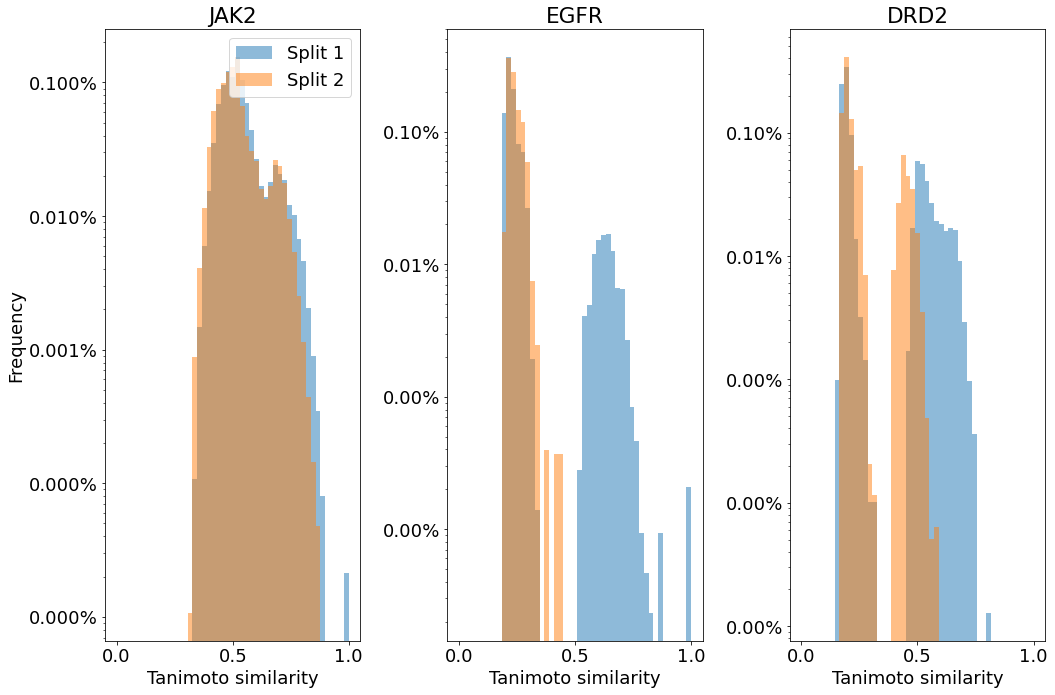

In [18]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 10*nrows), sharex=True)
for c_idx, chid in enumerate(chids):
    ax = axes[c_idx]
    assay_file ='assays/processed/' + str(chid) + '.csv'
    df = pd.read_csv(assay_file)    
    smiles_1, smiles_2, y1, y2, smiles_test, scores_1, scores_2 = fit_clfs(df, topliss_augmented=True)
    top_percentile = np.percentile(scores_1, 95)
    print(top_percentile)
    #top_percentile = 0.35
    similarities_1 = get_sims(np.array(smiles_test)[np.where(scores_1>top_percentile)[0]], np.array(smiles_1))
    similarities_2 = get_sims(np.array(smiles_test)[np.where(scores_1>top_percentile)[0]], np.array(smiles_2))        
    alpha=0.5
    bins = np.linspace(0,1,50)
    ax.hist([1-x for x in similarities_1], bins=bins, alpha=alpha, label='Split 1', weights=np.ones(len(similarities_1)) / len(similarities_1), log=True)
    ax.hist([1-x for x in similarities_2], bins=bins, alpha=alpha, label='Split 2', weights=np.ones(len(similarities_2)) / len(similarities_2), log=True)

    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    #ax.hist(scores_1)
    ax.set_title(chid2name[chid])
    low, high = ax.set_ylim()
    
    ax.set_title(chid2name[chid])


axes[0].legend()

axes[0].set_ylabel('Frequency')
    
for i in range(ncols):
    axes[i].set_xlabel('Tanimoto similarity')

xtext = -0.4
plt.tight_layout()
plt.savefig('similarities_top_5.pdf', bbox_inches='tight')

#fig.suptitle('Number of neighbours',fontweight ="bold")

In [114]:
run_directory = 'results/definitive_start_from_dataset/'
results_dir = Path(run_directory)

CHEMBL3888429
graph_ga


AttributeError: 'NoneType' object has no attribute 'reshape'

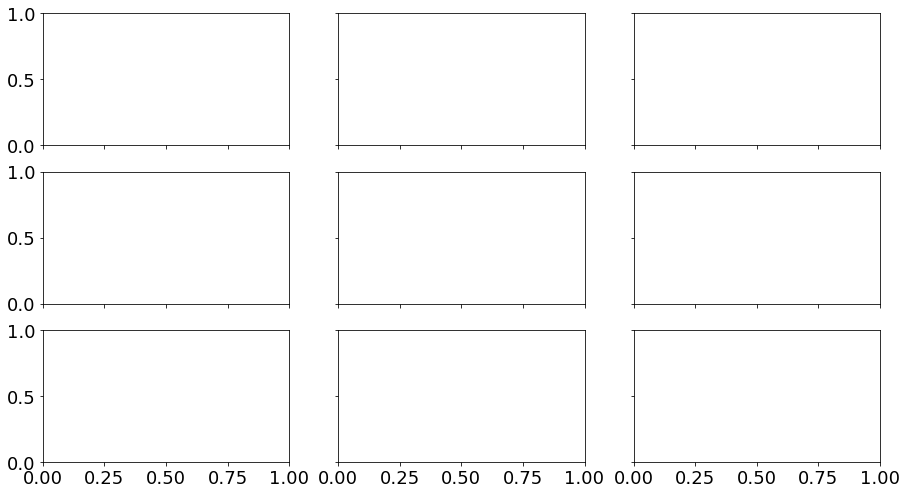

In [103]:
nrows = 3 # for two optimizers
order = ('Split1', 'Split1_alt', 'Split2')
legend_dict = dict(zip(order, ['Optimization score', 'Model control score', 'Data control score']))
opt_dict = {'graph_ga': 'GA', 'lstm_hc': 'LSTM', 'mso': 'PS'}
col_dict = dict(zip(order, ['blue', 'green', 'red']))
col_dict2 = dict(zip(order, ['cyan', 'magenta', 'green']))
ls_dict = dict(zip(order, ['-', '--', '-.']))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 2.75*nrows), sharex=True, sharey=True)
for r_idx, optimizer in enumerate(optimizers):
    for c_idx, chid in enumerate(chids):
        ax = axes[r_idx][c_idx]
        run_dir = os.path.join(run_directory, optimizer, chid)
        runs = [run for run in os.listdir(run_dir)]
        df1 = pd.read_csv(os.path.join(run_dir, runs[0], 'split1.csv'))
        smiles_1 = df1.smiles
        df2 = pd.read_csv(os.path.join(run_dir, runs[0], 'split2.csv'))
        smiles_2 = df2.smiles
        preds_internal, preds_external, auc, smiles, = load_chid(
            results_dir/optimizer/chid, order)
        assay_file ='assays/processed/' + str(chid) + '.csv'
        #df = pd.read_csv(assay_file)    
        #smiles_1, smiles_2, y1, y2, smiles_test, scores_1, scores_2 = fit_clfs(df, topliss_augmented=False)
        #top_percentile = np.percentile(scores_1, 95)
        #smiles = np.array(smiles)
        generated_smiles = []
        #if optimizer == 'graph_ga':
           # for i in range(smiles.shape[0]):
             #   generated_smiles.extend(smiles[i, -1, :])
        #else:
        #    for i in range(smiles.shape[0]):
        #        generated_smiles.extend(smiles[i, -1])
                
        #preds_internal, preds_external, auc, smiles, split_info = load_chid(Path(chid_path), order)

        # predictions of last iteration for all runs [10, nsamples]
        preds1 = [p[-1] for p in preds_internal['Split1']]
        preds2 = [p[-1] for p in preds_internal['Split2']]

        # final optimized smiles [10, nsamples]
        smiles_opt = [sl[-1] for sl in smiles if sl]
        print(chid)
        print(optimizer)
        similarities_1 = get_sims(np.array(smiles_opt), np.array(smiles_1))
        similarities_2 = get_sims(np.array(smiles_opt), np.array(smiles_2)) 
        
        alpha=0.5
        bins = np.linspace(0,1,50)
        ax.hist([1-x for x in similarities_1], bins=bins, alpha=alpha, label='Split 1', weights=np.ones(len(similarities_1)) / len(similarities_1), log=False)
        ax.hist([1-x for x in similarities_2], bins=bins, alpha=alpha, label='Split 2', weights=np.ones(len(similarities_2)) / len(similarities_2), log=False)

        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        #ax.hist(scores_1)
        #ax.set_title(chid2name[chid])
        low, high = ax.set_ylim()

        ax.set_title(optimizer)
        if c_idx==0:

            ax.legend()

            
            ax.set_ylabel(opt_dict[optimizer])

            for i in range(ncols):
                ax.set_xlabel('Tanimoto similarity')
for i, chid in enumerate(chids):
    title = chid2name.get(chid, chid)
    axes[0][i].set_title(title, fontsize=16)

    
plt.tight_layout()
plt.savefig('figures/similarities_generated.pdf', bbox_inches='tight')

results/definitive_chembl/
results/definitive_chembl/lstm_hc/CHEMBL1909203
results/definitive_chembl/lstm_hc/CHEMBL1909203/2021-07-20_06:06:07


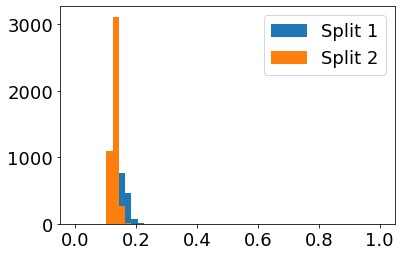

In [97]:
chid = "CHEMBL1909203"
optimizer = "lstm_hc"
print(run_directory)
run_dir = os.path.join(run_directory, optimizer, chid)
print(run_dir)
runs = [run for run in os.listdir(run_dir)]
print(os.path.join(run_dir, runs[0]))
df1 = pd.read_csv(os.path.join(run_dir, runs[0], 'split1.csv'))
smiles_1 = df1.smiles
df2 = pd.read_csv(os.path.join(run_dir, runs[0], 'split2.csv'))
smiles_2 = df2.smiles

#top_percentile = np.percentile(scores_1, 95)
smiles = ["Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(I)c(-c4cc(I)c(O)c(O)c4O)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(I)c4I)cc3-c3cc(-c4cccc(O)c4O)sc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(I)c(-c4cc(I)c(O)c(I)c4O)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cncc(-c6cccc(O)c6O)c5O)sc4I)cc3-c3ccc(I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ccc(-c5cc(I)c(O)c(I)c5I)s4)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(I)cc4I)cc3-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(-c5cc(-c6cccc(O)c6O)sc5I)sn4)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cncc(-c6cccc(O)c6O)c5O)sc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cccc(O)c5O)cc4Br)cc3-c3cc(-c4cc(I)sn4)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(I)c4O)cc3-c3cccc(-c4cccc(O)c4O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(I)c(O)c(I)c4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(I)c(O)c(I)c4O)cc(-c4cccc(O)c4O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3ccc(I)s3)c(O)c(-c3cc(-c4cc(-c5cc(I)c(O)c(I)c5O)sc4I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(-c4ccc(I)s4)s3)c(-c3sc(-c4cc(I)c(O)c(I)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cc(I)sc6-c6cccc(O)c6O)sc5I)cc4I)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(I)sc4I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(-c5cc(-c6cccc(O)c6O)sn5)sn4)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cccc(O)c5O)cc4I)cc3-c3cc(-c4cc(I)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)nc3-c3cc(-c4cc(I)c(O)c(I)c4I)cc(-c4cccc(O)c4O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4O)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cncc(-c5cc(I)c(O)c(I)c5O)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cccc(O)c5O)cc4Br)cc3-c3ccc(-c4cc(I)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(I)c(O)c(I)c4I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ssc3-c3scc(-c4c(I)cc(I)c(O)c4O)c3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(I)sc5I)cc4I)cc3-c3ccc(-c4cccc(O)c4O)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4O)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4I)cc3-c3ccc(I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3ccc(-c4cc(I)c(O)c(O)c4O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3ccc(I)s3)c(O)c(-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sc3-c3cc(I)c(O)c(I)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(I)c4O)cc3-c3cc(I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4Br)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3ccc(I)s3)c(O)c(-c3cc(-c4cc(-c5cc(I)c(O)c(I)c5I)sc4I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3cc(-c4cc(-c5cc(I)sn5)sc4I)cc(-c4cccc(O)c4O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cc(-c6cccc(O)c6O)sn5)sc4I)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cc(I)sc5I)sn4)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cncc(-c5cc(I)c(O)c(O)c5O)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4scc(-c5cc(I)c(O)c(I)c5O)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(-c5cc(-c6cccc(O)c6O)sc5I)sn4)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cc(I)sc6I)sc5I)cc4Br)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4cc(-c5cc(-c6cccc(O)c6O)sc5I)sc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4Br)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(I)sc5I)cc4Br)cc3-c3cc(-c4cccc(O)c4O)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4sc(-c5cc(I)sc5I)cc4-c4cccc(O)c4O)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(I)cc4O)cc3-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ssc3-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cccc(O)c5O)cc4O)cc3-c3cc(I)c(O)c(I)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(-c4cc(I)sc4I)sc3-c3sc(I)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ccc(-c4cc(-c5cccc(O)c5O)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(I)c4O)cc3-c3cc(-c4cccc(O)c4O)sc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ssc3-c3sc(-c4cc(I)c(O)c(I)c4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(I)sc4I)sc3-c3sc(-c4cccc(O)c4O)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(O)c(I)c(O)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sc3-c3cc(I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cc(-c4cc(-c5ccc(I)s5)sc4I)sc3-c3cccc(O)c3O)cc(-c3c(I)cc(I)c(O)c3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cccc(O)c5O)cc4Br)cc3-c3cc(-c4cc(I)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(I)cc4Br)cc3-c3cc(I)sc3-c3cc(-c4cccc(O)c4O)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(O)c4O)cc3-c3cccc(-c4cccc(O)c4O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cccc(O)c3O)cc(-c3c(O)c(I)cc(I)c3-c3cc(-c4cc(-c5ccc(I)s5)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4ssc4-c4cc(I)c(O)c(I)c4O)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4nc(-c5cc(I)c(O)c(I)c5I)sc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3F)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(I)sc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(-c4cc(I)c(O)c(I)c4O)sc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cc(I)sn6)sc5I)cc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4sc(-c5cc(I)sc5I)cc4-c4cccc(O)c4O)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cncc(-c5cc(I)c(O)c(I)c5I)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(I)c4I)cc3-c3cccc(-c4cccc(O)c4O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(-c6cccc(O)c6O)c5O)sc4I)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(I)c4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(I)sc3-c3cc(I)c(O)c(I)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cc(I)c(O)c(O)c5O)sc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cc(-c4cc(-c5ccc(I)s5)sc4I)sc3-c3c(I)cc(I)c(O)c3O)cc(-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cccc(O)c4O)cc3-c3cc(I)c(O)c(I)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(I)sc3-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3cc(-c4cc(-c5cc(I)sc5-c5cccc(O)c5O)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(I)c(O)c(I)c5I)cc4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4sc(-c5cc(I)sc5I)cc4-c4cccc(O)c4O)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cccc(O)c4O)sc3-c3cc(I)c(O)c(I)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cc(I)sc6I)sn5)cc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ccc(-c4cc(-c5cc(-c6cccc(O)c6O)sc5I)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(I)cc4O)cc3-c3ccc(-c4cc(-c5cccc(O)c5O)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(-c4cc(I)sc4-c4cccc(O)c4O)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(-c4cc(-c5cc(I)sn5)sn4)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cccc(O)c5O)cc4O)cc3-c3ccc(-c4cc(I)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4O)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4O)cc3-c3ccc(I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(I)sc3-c3ssc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sn4)cc3-c3cc(I)c(O)c(I)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sc4Br)cc3-c3cc(-c4cc(I)sn4)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4O)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cccc(O)c3O)cc(-c3c(O)c(I)cc(I)c3-c3sc(-c4cc(-c5ccc(I)s5)sc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3cc(-c4cc(-c5cc(-c6cccc(O)c6O)sc5I)sn4)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ssc3-c3ccc(-c4cc(-c5cccc(O)c5O)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3-c3cc(I)sc3-c3sc(I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cccc(O)c5O)cc4O)cc3-c3cc(-c4cc(I)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5sc(-c6cc(I)sc6I)cc5I)cc4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3ccc(-c4cc(-c5cc(I)sc5I)sn4)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sn4)cc3-c3cc(I)c(O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cc(-c6cccc(O)c6O)sc5I)sc4I)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4cc(-c5cc(I)sc5I)sc4-c4cccc(O)c4O)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(I)sc4I)sc3-c3ssc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sn4)cc3-c3cc(-c4cc(I)sn4)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cccc(-c4cc(I)c(O)c(I)c4O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(-c5cc(I)sc5-c5cccc(O)c5O)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(I)sc4I)sc3-c3sc(-c4cccc(O)c4O)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4cc(-c5cc(-c6cccc(O)c6O)sc5I)sn4)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(I)sc3-c3sc(I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cc(-c6cccc(O)c6O)sc5I)sn4)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccnc(-c3cc(-c4cc(-c5cc(I)sc5I)sn4)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cc(I)sc6I)sc5-c5cccc(O)c5O)cc4Br)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3scc(-c4c(I)cc(I)c(O)c4O)c3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3ccc(-c4cc(-c5cccc(O)c5O)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(I)sc3-c3sc(-c4cccc(O)c4O)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cccc(O)c3O)cc(-c3c(O)c(I)cc(I)c3-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(I)sc3-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ccc(-c4cc(-c5cc(I)sc5I)sc4-c4cccc(O)c4O)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3ccc(I)s3)c(O)c(-c3cc(-c4cc(-c5cc(I)c(O)c(O)c5O)sc4I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cccc(O)c5O)cc4Br)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cc(I)sc6I)sc5-c5cccc(O)c5O)cc4I)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cc(I)sc6-c6cccc(O)c6O)sc5I)cc4O)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(I)c(O)c(I)c5O)cc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4ssc4-c4cc(I)c(O)c(I)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(I)sc5I)cc4I)cc3-c3cc(I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(-c5cc(I)sc5I)sc4-c4cccc(O)c4O)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3cc(-c4cc(-c5cc(I)c(O)c(O)c5O)sc4I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(I)c(O)c(O)c4O)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(O)c4O)cc3-c3ccc(-c4cccc(O)c4O)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cccc(O)c5O)cc4I)cc3-c3cc(I)c(O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(-c4cccc(O)c4O)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3-c3cc(-c4cc(I)sn4)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sn5)cc4Br)cc3-c3ccccc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(-c4cc(I)c(O)c(O)c4O)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(I)c(O)c(I)c5I)cc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3ccc(I)s3)c(O)c(-c3ccc(-c4ccc(-c5cc(I)c(O)c(I)c5O)s4)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ssc3-c3ssc3-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cc(-c4cc(-c5ccc(I)s5)sc4I)sc3-c3cccc(O)c3O)cc(-c3c(I)cc(I)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4cccc(O)c4O)cc3-c3cc(-c4cc(I)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(-c5cc(I)sc5-c5cccc(O)c5O)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(I)sc5I)cc4-c4cccc(O)c4O)cc3-c3cc(I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cccc(O)c4O)cc3-c3cc(-c4cc(I)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3cc(-c4cc(-c5cc(I)sn5)sc4-c4cccc(O)c4O)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(-c4cc(I)c(O)c(I)c4I)sc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3ccc(I)s3)c(O)c(-c3sc(-c4cc(-c5cc(I)c(O)c(I)c5O)sc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cncc(-c6cccc(O)c6O)c5O)sc4I)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3cc(-c4cc(-c5cc(I)sc5I)sc4I)cc(-c4cccc(O)c4O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(-c4cc(I)sc4-c4cccc(O)c4O)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3ccc(I)s3)c(O)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(I)c(O)c(I)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cc(-c4cc(-c5ccc(I)s5)sc4I)sc3-c3cccc(O)c3O)c(O)c(-c3cc(I)c(O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(I)sc4I)cc3-c3cc(-c4cccc(O)c4O)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(I)sc3-c3ccc(-c4cc(-c5cccc(O)c5O)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(I)sc5I)cc4I)cc3-c3cc(-c4cccc(O)c4O)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cc(I)sc5I)sc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4I)cc3-c3ccccc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cccc(-c6cccc(O)c6O)c5O)sc4I)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(I)c(O)c(O)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(I)c(-c4cc(I)c(O)c(O)c4O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cc(-c4cc(-c5ccc(I)s5)sc4I)sc3-c3cccc(O)c3O)cc(-c3cc(I)c(O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(-c4cc(-c5cccc(O)c5O)sn4)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4nss4)cc3-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4cccc(O)c4O)cc3-c3cc(I)c(O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4O)cc3-c3cc(I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cncc(-c6cccc(O)c6O)c5O)sc4I)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(-c4cc(-c5cc(I)sc5I)sn4)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cc(I)sc5I)sc4-c4cccc(O)c4O)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cc(-c6cccc(O)c6O)sc5I)sn4)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(-c4cc(I)c(O)c(I)c4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(-c5cccc(O)c5O)c4O)cc3-c3cc(I)c(O)c(I)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(O)c4O)cc3-c3cc(I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4nss4)cc3-c3ccc(-c4cc(-c5cccc(O)c5O)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2sccc2-c2ssc2-c2scc(-c3cccc(O)c3O)c2-c2scc(-c3ccc(I)s3)c2-c2c(I)cc(I)c(O)c2O)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cc(-c4cc(-c5ccc(I)s5)sc4I)sc3-c3cccc(O)c3O)cc(-c3c(O)c(I)cc(I)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sn4)cc3-c3cc(-c4cc(I)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(I)c(O)c(O)c5O)cc4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3ccc(-c4cccc(O)c4O)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cncc(-c5cccc(O)c5O)c4O)cc3-c3ccc(-c4cc(I)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(I)cc3-c3ccc(-c4cc(-c5cccc(O)c5O)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(I)cc4O)cc3-c3cccc(-c4cccc(O)c4O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ssc3-c3ssc3-c3sc(-c4cc(I)sc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(I)c(O)c(I)c4I)cc(-c4cccc(O)c4O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cc(-c4cc(-c5ccc(I)s5)sc4I)sc3-c3cccc(O)c3O)cc(-c3cc(I)c(O)c(I)c3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4cc(-c5cc(-c6cccc(O)c6O)sc5I)sn4)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cccc(O)c5O)cc4I)cc3-c3cc(I)c(O)c(I)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3-c3cc(I)sc3-c3cc(I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ssc3-c3scc(-c4cccc(O)c4O)c3-c3c(I)cc(I)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3-c3ccc(-c4ccc(I)s4)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(-c5cccc(O)c5O)c4O)cc3-c3cc(-c4cc(I)sn4)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cc(I)sc6I)sc5I)cc4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cc(I)sc6I)sc5I)cc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sc3-c3cc(I)c(O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cncc(-c5cccc(O)c5O)c4O)cc3-c3cc(-c4cc(I)sn4)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(I)cc4I)cc3-c3cc(-c4cc(-c5cccc(O)c5O)sn4)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cccc(O)c4O)sc3-c3ccc(-c4cc(I)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3cc(-c4cc(I)c(O)c(I)c4O)cc(-c4cccc(O)c4O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cc(I)sn6)sc5I)cc4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cccc(O)c4O)cc3-c3cc(I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(I)sc3-c3cc(I)c(O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3ccc(-c4cc(-c5cc(I)sc5-c5cccc(O)c5O)sn4)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4O)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4I)cc3-c3cc(I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(I)cc3-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4ccc(-c5cc(-c6cccc(O)c6O)sc5I)s4)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4O)cc3-c3ccccc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(-c4cc(-c5cc(I)sc5I)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2scc(-c3cccc(O)c3O)c2-c2scc(-c3cc(I)c(O)c(O)c3O)c2-c2c(I)cc(I)c(O)c2O)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(I)sc3-c3sc(-c4cc(I)sc4I)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(I)sc4I)cc3-c3cc(-c4cccc(O)c4O)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cc(-c4cc(-c5ccc(I)s5)sc4I)sc3-c3cccc(O)c3O)c(O)c(-c3cc(I)c(O)c(I)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cncc(-c5cccc(O)c5O)c4O)cc3-c3cc(I)c(O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(-c4cc(-c5cc(I)sc5I)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3ccc(-c4cc(I)c(O)c(I)c4O)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cc(-c4cc(-c5ccc(I)s5)sc4I)sc3-c3c(O)c(I)cc(I)c3O)cc(-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(O)c4O)cc3-c3cc(-c4cccc(O)c4O)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4sc(-c5cc(I)sc5I)cc4Br)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cc(I)sc5-c5cccc(O)c5O)sc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4cc(-c5cc(-c6cccc(O)c6O)sc5I)sc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3-c3cc(I)sc3-c3sc(I)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(I)cc4I)cc3-c3cc(-c4cc(I)sc4I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4O)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sn4)cc3-c3cc(-c4cc(I)sc4-c4cccc(O)c4O)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4I)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4Br)cc3-c3ccccc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3ccc(-c4cc(-c5cc(I)sc5I)sc4-c4cccc(O)c4O)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ssc3-c3sc(-c4cc(I)sc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(I)sc4I)cc3-c3ccc(-c4cccc(O)c4O)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(I)cc3-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4Br)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(O)c(I)c(O)c5O)cc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4cccc(O)c4O)cc3-c3ccc(-c4cc(I)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3ccc(I)s3)c(O)c(-c3sc(-c4cc(-c5cc(I)c(O)c(O)c5O)sc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4I)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(I)c4O)cc3-c3cc(-c4cccc(O)c4O)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4Br)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cc(I)sc6I)sc5-c5cccc(O)c5O)cc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(I)c4I)cc3-c3ccc(-c4cccc(O)c4O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cc(-c6cccc(O)c6O)sn5)sc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(I)sc3-c3sc(-c4cccc(O)c4O)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(-c4cccc(O)c4O)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(I)c(O)c(O)c5O)cc4Br)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4cc(I)c(O)c(I)c4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(-c5cc(I)sc5I)sc4I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cc(-c4ccc(I)s4)sc3-c3cc(I)c(O)c(I)c3O)cc(-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ssc3-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sc4Br)cc3-c3cc(-c4cc(I)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3-c3ccc(-c4cccc(O)c4O)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cc(I)sn5)sc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sn4)cc3-c3cc(I)sc3-c3sc(-c4cccc(O)c4O)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3ccc(-c4cc(I)c(O)c(O)c4O)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4cccc(O)c4O)cc3-c3cc(I)c(O)c(I)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(I)sc5I)cc4I)cc3-c3cc(-c4cccc(O)c4O)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4I)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cccc(O)c4O)cc3-c3cc(I)c(O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4ccc(-c5cc(-c6cccc(O)c6O)sc5I)s4)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(-c4cccc(O)c4O)sc3-c3cc(I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sn4)cc3-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(I)c4I)cc3-c3cc(-c4cccc(O)c4O)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(I)sc5I)cc4O)cc3-c3cc(I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3ccc(-c4cc(-c5cc(I)sn5)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(I)sc3-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(I)c4I)cc3-c3cc(-c4cccc(O)c4O)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4O)cc3-c3cc(I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cccc(O)c3O)cc(-c3c(O)c(I)cc(I)c3-c3sc(-c4cc(-c5ccc(I)s5)sc4I)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(-c4cccc(O)c4O)sc3-c3sc(I)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(-c5cc(I)c(O)c(I)c5O)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(I)sc3-c3cc(-c4cccc(O)c4O)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4cc(I)c(O)c(I)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(I)sc5I)cc4Br)cc3-c3cc(-c4cccc(O)c4O)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(I)sc5I)cc4Br)cc3-c3cc(I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(I)c(O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ccc(-c5cc(I)c(O)c(O)c5O)c(O)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ccc(-c4cc(I)c(O)c(O)c4O)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cccc(-c4cc(I)c(O)c(O)c4O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4cc(-c5cc(-c6cccc(O)c6O)sc5I)sc4I)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(-c4cc(-c5cc(I)sn5)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5nss5)cc4I)cc3-c3cc(-c4cc(I)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cccc(O)c5O)cc4I)cc3-c3ccccc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(-c5cc(-c6cccc(O)c6O)sc5I)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(I)c(-c4cccc(O)c4O)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(-c4cc(-c5cc(I)sn5)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(I)sc3-c3cc(I)c(O)c(O)c3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4O)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(I)c(O)c(I)c5I)cc4-c4cccc(O)c4O)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cncc(-c5cccc(O)c5O)c4O)cc3-c3ccccc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ccc(-c4cc(-c5cc(I)sc5I)sc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4ccc(-c5cc(I)sc5I)s4)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cc(I)sn5)sc4-c4cccc(O)c4O)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(-c5cc(I)sn5)sc4I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cc(I)sc6I)sn5)cc4Br)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3ccc(I)s3)c(O)c(-c3ccc(-c4cc(-c5cc(I)c(O)c(I)c5I)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4O)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4cc(-c5cc(-c6ccc(I)s6)sc5I)sc4I)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cccc(O)c4O)cc3-c3ccc(-c4cc(I)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(I)cc4I)cc3-c3ccc(-c4cc(-c5cccc(O)c5O)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(-c5cccc(O)c5O)c4O)cc3-c3cc(-c4cc(I)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(I)sc3-c3sc(-c4cc(I)sc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3cc(-c4cc(-c5cc(I)sc5I)sc4-c4cccc(O)c4O)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3ccc(I)s3)c(O)c(-c3sc(-c4cc(-c5cc(I)c(O)c(I)c5I)sc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(I)cc4O)cc3-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(I)sc4I)cc3-c3cc(I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cc(I)sc6-c6cccc(O)c6O)sc5I)cc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(-c4cc(I)sc4I)sc3-c3sc(I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(I)cc4O)cc3-c3cc(-c4cc(I)sc4I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cc(I)sc5-c5cccc(O)c5O)sc4I)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(-c4cc(-c5cc(I)sc5I)sn4)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cccc(O)c5O)cc4Br)cc3-c3cc(I)c(O)c(I)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(I)c(O)c(I)c3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(-c5cc(I)sc5I)sc4-c4cccc(O)c4O)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5sc(-c6cc(I)sc6I)cc5I)cc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ssc3-c3sc(-c4cccc(O)c4O)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ssc3-c3sc(-c4cc(I)c(O)c(O)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(I)c(O)c(I)c4O)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sn4)cc3-c3ccc(-c4cc(-c5cccc(O)c5O)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(I)c(O)c(O)c4O)cc(-c4cccc(O)c4O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3-c3cc(I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4Br)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(I)sc3-c3cc(-c4cc(I)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4cccc(O)c4O)cc3-c3ccc(-c4cc(I)sn4)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2sccc2-c2ssc2-c2scc(-c3ccc(I)s3)c2-c2scc(-c3cccc(O)c3O)c2-c2c(I)cc(I)c(O)c2O)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4I)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sc3-c3sc(I)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ccc(-c4cc(-c5cc(I)sc5-c5cccc(O)c5O)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ccc(-c5cc(I)c(O)c(O)c5O)s4)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(I)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(I)sc3-c3sc(-c4cc(I)sc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3-c3ccc(-c4cc(I)sn4)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cccc(O)c5O)cc4Br)cc3-c3cc(I)c(O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(-c5cc(-c6cccc(O)c6O)sc5I)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(O)c4O)cc3-c3ccc(-c4cccc(O)c4O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(O)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3ccc(-c4cc(-c5cc(-c6cccc(O)c6O)sc5I)sn4)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(I)sc3-c3cc(-c4cc(I)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(-c4cccc(O)c4O)sc3-c3sc(I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cncc(-c5cccc(O)c5O)c4O)cc3-c3cc(I)c(O)c(I)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cncc(-c5cccc(O)c5O)c4O)cc3-c3cc(-c4cc(I)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3cc(-c4cc(-c5cc(-c6cccc(O)c6O)sc5I)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(-c5cc(I)sc5I)sn4)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ccc(-c5cc(I)c(O)c(I)c5O)c(O)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cccc(-c4cccc(O)c4O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(I)sc5I)cc4O)cc3-c3ccc(-c4cccc(O)c4O)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sn4)cc3-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(O)c4O)cc3-c3cc(-c4cccc(O)c4O)sc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cc(I)c(O)c(I)c5I)sc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(-c5cc(-c6cccc(O)c6O)sn5)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(-c4cc(I)sc4I)sc3-c3cc(I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3cc(-c4cc(I)c(O)c(I)c4I)cc(-c4cccc(O)c4O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4cc(-c5cc(-c6cccc(O)c6O)sc5I)sc4I)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4sc(-c5cc(I)sc5I)cc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cc(I)sc6I)sn5)cc4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3cc(I)sc3-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4cccc(O)c4O)cc3-c3cc(I)c(O)c(I)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cccc(O)c3O)cc(-c3cncc(-c4cc(I)c(O)c(I)c4O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cc(-c6cccc(O)c6O)sn5)sc4I)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3ccc(-c4cc(-c5cc(-c6cccc(O)c6O)sc5I)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4nss4)cc3-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4Br)cc3-c3cc(I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cc(-c6cccc(O)c6O)sc5I)sn4)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3ccc(-c4cc(-c5cc(I)sc5-c5cccc(O)c5O)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4cccc(O)c4O)cc3-c3ccc(-c4cc(I)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(-c5cc(-c6cccc(O)c6O)sn5)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3ccc(-c4cc(-c5ccc(I)s5)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3cc(-c4cc(-c5cc(I)c(O)c(I)c5I)sc4I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cccc(-c6cccc(O)c6O)c5O)sc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4I)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cc(-c4cc(I)c(O)c(O)c4O)sc3I)cc(-c3cc(I)c(O)c(-c4cccc(O)c4O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3cc(-c4cc(I)c(O)c(O)c4O)cc(-c4cccc(O)c4O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4ccc(-c5cc(-c6cccc(O)c6O)sc5I)s4)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3ccc(-c4ccc(-c5cccc(O)c5O)s4)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4O)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cccc(O)c5O)cc4I)cc3-c3ccc(-c4cc(I)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4cc(I)c(O)c(O)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4nsc(-c5cc(-c6cccc(O)c6O)sc5I)n4)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ssc3-c3ssc3-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4I)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cc(I)sc6-c6cccc(O)c6O)sc5I)cc4Br)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ccc(-c5cc(I)c(O)c(I)c5O)s4)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4sc(I)cc4I)cc3-c3cc(-c4cccc(O)c4O)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3ccc(-c4cc(I)c(O)c(I)c4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(I)c(O)c(I)c5I)cc4Br)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(-c4cc(I)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3cc(-c4cc(O)c(O)c(-c5cccc(O)c5O)c4O)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cnn(-c6cccc(O)c6O)c5O)sc4I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3ccc(-c4cc(I)c(O)c(I)c4O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(-c4cc(-c5ccnc(O)c5O)sn4)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ssc3-c3sc(-c4cccc(O)c4O)cc3-c3cc(I)c(O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3cc(-c4cc(-c5cc(I)c(O)c(I)c5O)sc4I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(O)c4O)cc3-c3cc(-c4cccc(O)c4O)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3-c3cc(I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(I)c(O)c(I)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cc(-c4cc(-c5ccc(I)s5)sc4I)sc3I)cc(-c3c(O)c(I)cc(I)c3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(I)cc4I)cc3-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cccc(O)c3O)cc(-c3c(O)c(I)cc(I)c3-c3sc(I)cc3-c3ccc(-c4ccc(I)s4)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3cc(-c4cc(-c5cc(-c6cccc(O)c6O)sn5)sc4I)cc(I)c3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3ccc(-c4cccc(O)c4O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3ccc(-c4cc(I)c(O)c(I)c4O)c(I)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(I)c4O)cc3-c3ccc(-c4cccc(O)c4O)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sn4)cc3-c3cc(I)sc3-c3cc(I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4cc(-c5cc(I)sc5I)sc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3ccc(-c4cc(-c5cccc(O)c5O)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ccc(-c4cc(-c5cc(-c6cccc(O)c6O)sn5)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4cc(-c5cc(I)sc5I)sc4-c4cccc(O)c4O)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cc(I)sn6)sc5I)cc4Br)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4ssc4-c4cccc(O)c4O)cc3-c3cc(I)c(O)c(I)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(I)cc3-c3cc(-c4cc(I)sc4I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4ssc4-c4cccc(O)c4O)cc3-c3ccc(I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cc(I)sc6I)sc5-c5cccc(O)c5O)cc4O)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sn4)cc3-c3ccc(-c4cc(I)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sn4)cc3-c3cc(I)sc3-c3sc(I)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(I)c4O)cc3-c3cc(-c4cccc(O)c4O)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4I)cc3-c3cc(I)c(O)c(O)c3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3ccc(-c4cc(-c5cc(-c6cccc(O)c6O)sn5)sc4I)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4sc(-c5cc(-c6cccc(O)c6O)sc5I)cc4O)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cccc(O)c5O)cc4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cccc(O)c5O)cc4O)cc3Br)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sn4)cc3-c3cc(-c4cc(I)sc4I)sc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3ssc3-c3sc(-c4cc(I)c(O)c(I)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cc(-c4cc(-c5ccc(I)s5)sc4I)sc3-c3c(I)cc(I)c(O)c3I)cc(-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4sc(-c5cc(I)sc5I)cc4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(I)c(O)c(I)c5O)cc4Br)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(I)c4I)cc3-c3ccc(-c4cccc(O)c4O)s3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cccc(O)c5O)cc4O)cc3-c3cc(I)c(O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ccc(I)s4)cc3-c3cc(-c4cc(I)sc4I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(-c6cc(I)sc6-c6cccc(O)c6O)sc5I)cc4O)cc3I)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(I)cc4Br)cc3-c3cc(-c4cc(I)sc4I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3ccc(-c4cc(I)c(O)c(I)c4O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cccc(O)c4O)cc3-c3cc(I)c(O)c(I)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cccc(O)c4O)sc3-c3cc(I)c(O)c(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)c(O)c(I)c4I)cc3-c3cc(I)sc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3sc(-c4sc(-c5cc(I)sc5I)cc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(I)sc4-c4cc(I)c(O)c(I)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4sc(-c5cc(I)c(O)c(O)c5O)cc4I)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sc3-c3cc(I)c(O)c(I)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3ssc3-c3scc(-c4cc(I)c(O)c(O)c4O)c3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4cc(-c5cccc(O)c5O)sc4I)cc3O)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(I)cc3-c3cc(-c4cc(-c5cccc(O)c5O)sc4I)sn3)c2)s1", "Oc1ccccc1-c1nnc(-c2ccc(-c3ccc(I)s3)c(-c3sc(-c4ssc4-c4ssc4-c4cc(I)c(O)c(O)c4O)cc3-c3cccc(O)c3O)c2)s1", "Oc1ccccc1-c1nnc(-c2cc(-c3cccc(O)c3O)cc(-c3c(O)c(I)cc(I)c3-c3sc(-c4cc(I)sc4I)cc3-c3ccc(I)s3)c2)s1"]
generated_smiles = np.array(smiles)


similarities_1 = get_sims(generated_smiles, np.array(smiles_1))
similarities_2 = get_sims(generated_smiles, np.array(smiles_2))
bins = np.linspace(0,1,50)
plt.hist([1-x for x in similarities_1], bins=bins, label='Split 1')
plt.hist([1-x for x in similarities_2], bins=bins, label='Split 2')
plt.legend()

In [110]:
from rdkit import Chem
from rdkit.Chem import Draw
# from svglib.svglib import svg2rlg
# from reportlab.graphics import renderPDF

from IPython.display import display, SVG
def forfor(a):
    return [item for sublist in a for item in sublist]

def m7s(smiles):
    return Chem.MolFromSmiles(smiles)

from sklearn.neighbors import NearestNeighbors
def get_dists(X, Y):
    neigh = NearestNeighbors(10, 0.4, metric='jaccard', algorithm='brute')
    neigh.fit(X)
    dist, idx = neigh.kneighbors(Y)
    return dist, idx

from collections import Counter

In [111]:
def get_nn(si, so):
    smiles_train = list(si[si['Split'] == 0].smiles)
    smiles_test = list(si[si['Split'] == 1].smiles)

    ecfp_train = np.array(ecfp(smiles_train), dtype=bool)
    ecfp_test = np.array(ecfp(smiles_test), dtype=bool)
    ecfp_opt = np.array(ecfp(so), dtype=bool)

    # get nearest neighbours and distances
    dist_train, idx_train = get_dists(ecfp_train, ecfp_opt)
    dist_test, idx_test = get_dists(ecfp_test, ecfp_opt)

    nnd_train = dist_train[:,0]
    nnd_test = dist_test[:,0]

    nn_train = [smiles_train[i] for i in idx_train[:,0]]
    nn_test = [smiles_test[i] for i in idx_test[:,0]]
    return nnd_train, nnd_test, nn_train, nn_test

In [116]:
from plot_utils import load_chid

results = {}
for optimizer in ['graph_ga', 'lstm_hc', 'mso']:
    if optimizer in results:
        continue
    
    results[optimizer] = {}
    for chid in chids:
        chid_path = results_dir/optimizer/chid
        print(chid_path)
        # split info contains information about the data splits. a list of dataframes
        preds_internal, preds_external, auc, smiles, split_info = load_chid(Path(chid_path), order)

        # predictions of last iteration for all runs [10, nsamples]
        preds1 = [p[-1] for p in preds_internal['Split1']]
        preds2 = [p[-1] for p in preds_internal['Split2']]

        # final optimized smiles [10, nsamples]
        smiles_opt = [sl[-1] for sl in smiles]

        # for each run calculate nearest neighbours
        accumulate = []
        for si, so in zip(split_info, smiles_opt):
            accumulate.append(get_nn(si, so))

        nnd_train, nnd_test, nn_train, nn_test = zip(*accumulate)
        results[optimizer][chid] = (smiles_opt, preds1, preds2, nnd_train, nnd_test, nn_train, nn_test)

results/definitive_start_from_dataset/graph_ga/CHEMBL3888429
results/definitive_start_from_dataset/graph_ga/CHEMBL1909203
results/definitive_start_from_dataset/graph_ga/CHEMBL1909140
results/definitive_start_from_dataset/lstm_hc/CHEMBL3888429
results/definitive_start_from_dataset/lstm_hc/CHEMBL1909203
results/definitive_start_from_dataset/lstm_hc/CHEMBL1909140
results/definitive_start_from_dataset/mso/CHEMBL3888429
results/definitive_start_from_dataset/mso/CHEMBL1909203
results/definitive_start_from_dataset/mso/CHEMBL1909140


graph_ga
lstm_hc
mso


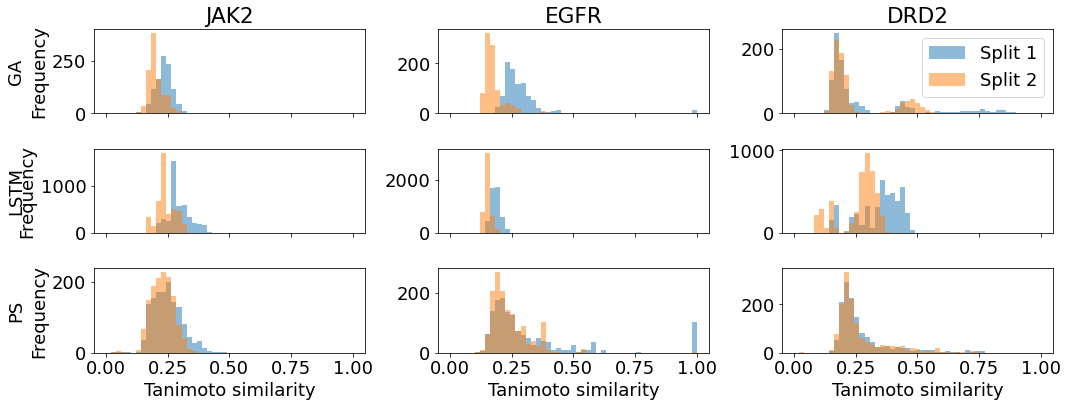

In [117]:
title = True
nrows = 3
ncols = len(chids)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6), sharex=True)

for r_idx, (optimizer, opt_results) in enumerate(results.items()):
    print(optimizer)
    for c_idx, (chid, values) in enumerate(opt_results.items()):
        ax = axes[r_idx][c_idx]
        smiles_opt, preds1, preds2, nnd_train, nnd_test, nn_train, nn_test = values
    
        sims_train = 1-np.array(forfor(nnd_train))
        sims_test = 1-np.array(forfor(nnd_test))
        
        alpha=0.5
        bins = np.linspace(0,1,50)
        ax.hist(sims_train, bins=bins, alpha=alpha, label='Split 1')
        ax.hist(sims_test, bins=bins, alpha=alpha, label='Split 2')

        if r_idx==0:
            ax.set_title(chid2name[chid])


axes[0][2].legend()

for i in range(nrows):
    axes[i][0].set_ylabel('Frequency')
    
for i in range(ncols):
    axes[-1][i].set_xlabel('Tanimoto similarity')

xtext = -0.4
axes[0][0].text(xtext, sum(axes[0][0].get_ylim()) / 2 , "GA", rotation=90, verticalalignment='center')
axes[1][0].text(xtext, sum(axes[1][0].get_ylim()) / 2, "LSTM", rotation=90, verticalalignment='center')
axes[2][0].text(xtext, sum(axes[2][0].get_ylim()) / 2, "PS", rotation=90, verticalalignment='center')
plt.tight_layout()
plt.savefig('./figures/NND_hist.pdf')